# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1</center>
## <center>Checkpoint 3 : Ensambles de modelos</center> 

# Consigna

  1. Construir un **clasificador KNN** optimizar sus hiperparámetros mediante k-fold
Cross Validation
  2. Construir un **clasificador SVM** variando el kernel y los parámetros.
  3. Construir un **clasificador RF** y optimizar sus hiperparámetros mediante **k-fold Cross Validation**
  4. Construir un **clasificador XGBoost** y optimizar sus hiperparámetros.
  5. Construir un **ensamble híbrido** tipo **Voting** y otro tipo **Stacking**.
  6. Evaluar la performance de todos los modelos en entrenamiento y validación explicar todas las métricas y mostrar la matriz de confusión.
  7. Generar predicciones con el set de test y realizar los submits correspondientes en la competencia de Kaggle.

# Inicializacion de entorno

## Librerías

In [25]:
!pip install dtreeviz


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from datetime import datetime, timezone, timedelta
import time

#Preprocesamiento
from sklearn.preprocessing import (
    KBinsDiscretizer,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,

)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    KFold,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
    cross_validate,
)

#modelos
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegressionCV,
    LogisticRegression
)
from sklearn.tree import (
    DecisionTreeClassifier, 
    export_graphviz
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

#ensambles 
from sklearn.ensemble import (
    IsolationForest, 
    RandomForestClassifier, 
    GradientBoostingRegressor,
    StackingClassifier,
    RandomForestClassifier,
    VotingClassifier
)
import xgboost as xgb
from sklearn.pipeline import Pipeline

#metricas
from sklearn.metrics import(
    confusion_matrix,
    classification_report,
    make_scorer,
    recall_score, 
    accuracy_score,
    f1_score,
    precision_score
)
from collections import defaultdict

#Visualización
import dtreeviz.trees as dtreeviz
import plotly.express as px
import plotly.graph_objects as go
from sklearn import tree

#guardado 
from google.colab import files
import pickle

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Funciones

### Métricas

In [27]:
def metricas_modelo(test, pred, title="Matriz de confusión y métricas para el modelo"):
  #Calculo las métricas en el conjunto de evaluación
  accuracy=accuracy_score(test, pred)
  recall=recall_score(test, pred)
  f1=f1_score(test, pred)
  precision=precision_score(test, pred)

  metrics=[[str(round(accuracy,5)), str(round(recall,5)), str(round(precision,5)), str(round(f1,5))]]
  labels=['Accuracy', 'Recall', 'Precision', 'F1']
  
  matriz=confusion_matrix(test, pred)
  plt.title(title)
  t = plt.table(cellText=metrics,
            colLabels=labels,
            bbox=(1.5, .1, 0.75, 0.75))
  t.auto_set_font_size(False)
  t.set_fontsize(11)


  #Grafico la matriz de confusión
  sns.heatmap(matriz,cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [28]:
def timer_flag(t):
    time_format = time.strftime("%M:%S", time.gmtime(round(t)))
    print("Tiempo transcurrido: ", time_format, " minutos")
    print("_______________________________")

In [29]:
def metricas_cv(model, t=None):
  print("Resultados del Cross Validation")
  print("_______________________________")
  timer_flag(t)
  #Mejores hiperparametros
  print("Mejores hiperparametros: ", model.best_params_)
  #Mejor métrica
  print("Mejor métrica F1: ",model.best_score_)

In [30]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

### Gráficos

In [31]:
plt.style.use('ggplot')

In [32]:
#Funcion para plotear a performance
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [33]:
def plot_tree(data, model):
    plt.figure(figsize=(12,12))
    tree_plot=tree.plot_tree(model.estimators_[48],
                            max_depth=4,
                            feature_names=data.columns.to_list(),
                            filled=True,
                            rounded=True,
                            class_names=True)

    plt.show(tree_plot)

### Train

In [34]:
def Randomized_Cross_Validation(x_data, y_data, classifier, parameters, folds=5, iterations=10):
    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(sk.metrics.f1_score)

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    model_rand = RandomizedSearchCV(estimator=classifier, 
                                    param_distributions = parameters, 
                                    scoring=scorer_fn, 
                                    cv=kfoldcv, 
                                    n_iter=iterations) 

    #Se entrena el modelo tomando el tiempo que tarda
    t_inicio = time.perf_counter()
    model_rand.fit(x_data, y_data)
    t_final = time.perf_counter()

    #Se muestran las métricas más relevantes
    metricas_cv(model_rand, t_final-t_inicio)

    return model_rand.best_estimator_

In [35]:
def Grid_Cross_Validation(x_data, y_data, classifier, parameters, folds=5):

    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(sk.metrics.f1_score)

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)
   
    model_grid = GridSearchCV(estimator=classifier, param_grid=parameters, scoring=scorer_fn, cv=kfoldcv, n_jobs=-1)
    
    #Se entrena el modelo tomando el tiempo que tarda
    t_inicio = time.perf_counter()
    model_grid.fit(x_data, y_data)
    t_final = time.perf_counter()

    metricas_cv(model_grid, t_final-t_inicio)

    return model_grid.best_estimator_

In [36]:
def make_prediction(model, x_data, y_data):
    #Predicción
    y_pred = model.predict(x_data)

    metricas_modelo(y_data, y_pred)


La métricas para evaluar el rendimiento de un modelo se calculan comparando los valores predichos frente a los reales en un conjunto de testeo, es así que surgen diferentes valores:

*   **Matriz de confusión**:


|            | predicted    |            |            |
|:----------:|:------------:|:----------:|:----------:|
|            |              |      0     |       1    |
| real       |0             | TN         | FP         |
|            |1             | FN         | TP         |

**TN**: True Negative; **FN**: False Negative; **FP**: False Positive; **TP**: True Positive



---


*   **Precisión** (precision):
    \begin{align}
        precision=\frac{TP}{TP+FP}
    \end{align}

    La *precisión* indica que cuanto más se acerca a 1, menos falsos positivos tuvo y por lo tanto todos las predicciones sobre la positiva fueron correctas. Esta métrica valora la calidad del modelo.


---


*   **Exhaustividad** (recall):
    \begin{align}
        recall=\frac{TP}{TP+FN}
    \end{align}

    Si el *exhaustividad* se acerca a 1, quiere decir que no se quedó ningún negativo verdadero afuera. Esta métrica valora la cantidad de valores que pueden identificar del modelo. 


---


*   **F1**:
    \begin{align}
        F1=2.\frac{precision.recall}{precision+recall}
    \end{align}

    *F1* se utiliza para combinar las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de ambas métricas.


---


*   **Exactitud** (accuracy):
\begin{align}
    accuracy=\frac{TP+TN}{TP++TN+FP+FN}
\end{align}

  La *exactitud* indica cual es el porcentaje de aciertos del modelo. Sin embargo no brinda mucha información sobre cómo se distribuyen los valores.

    

## Datasets

In [37]:
db_train_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/TP1/processed/hotels_train.csv'
db_test_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/TP1/processed/hotels_test.csv'
df_train = pd.read_csv(db_train_url)
df_test_submission = pd.read_csv(db_test_url)

In [38]:
df_work_train = df_train.copy()
df_work_test_submission = df_test_submission.copy()

# Preprocesamiento del dataframe

## Separación en x e y

Separacion entre columnas de decision y de target

In [16]:
#Creo un dataset con los features que voy a usar para clasificar
x_work = df_work_train.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
y_work = df_work_train['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x_work,
                                                    y_work, 
                                                    test_size=0.25,  #proporcion 75/25
                                                    random_state=2, #semilla
                                                    stratify=df_work_train['is_canceled'].values) 

x_test_submission = df_work_test_submission.drop(['id'], axis='columns', inplace=False)                                             

# Entrenamiento y prediccion de modelos

In [39]:
best_model_submission = {"name": "", "model": None}

## KNN (k-nearest neighbors)

In [ ]:
#Clasificador KNN
knn_class = KNeighborsClassifier()
knn_class.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

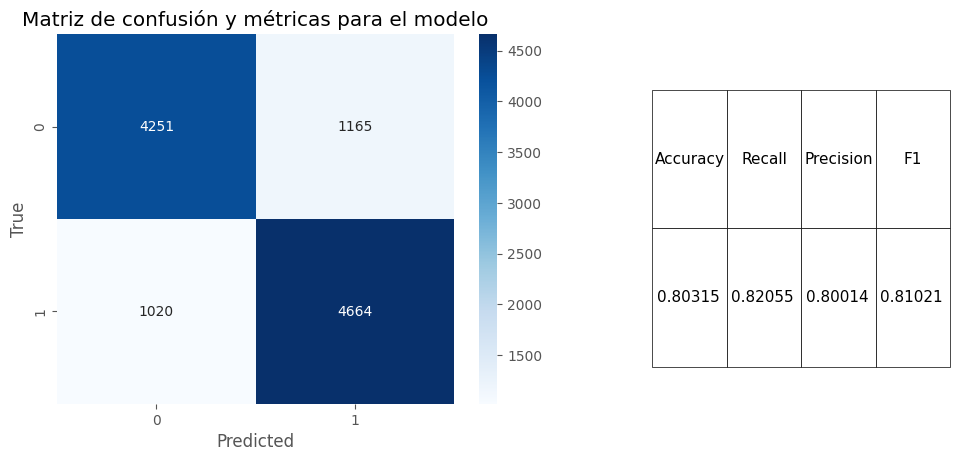

In [ ]:
#Entrenar el modelo
knn_class.fit(x_train, y_train)

#Predicción sobre test
y_pred_knn = knn_class.predict(x_test)

metricas_modelo(y_test, y_pred_knn)

De la matriz de confusión podemos apreciar como de los 13847 casos se obtuvieron:

*   5542 Verdaderos Negativos
*   5579 Verdaderos Positivos
*   1383 Falsos Positivos
*   1343 Falsos Negativos

Lo cual nos indica un porcentaje de alrededor del, 80% de aciertos (Accuracy), 80% de exhaustividad (Recall), 80% precisión y un rendimiento F1 de 0.80.



### Hiperparametros optimizados por CV

In [ ]:
#Grilla de Parámetros
params = { 
    'n_neighbors':range(1,30), 
    'weights':['distance','uniform'],
    'algorithm':['ball_tree', 'kd_tree', 'brute'],
    'metric':['euclidean','manhattan','chebyshev']
}

#Random Search con 10 Folds y 20 iteraciones
best_knn = Randomized_Cross_Validation(x_train, y_train, knn_class, params, 10, 20)


KeyboardInterrupt: ignored

Se realiza una prediccion de subconjunto de test con el KNN con mejores parámetros

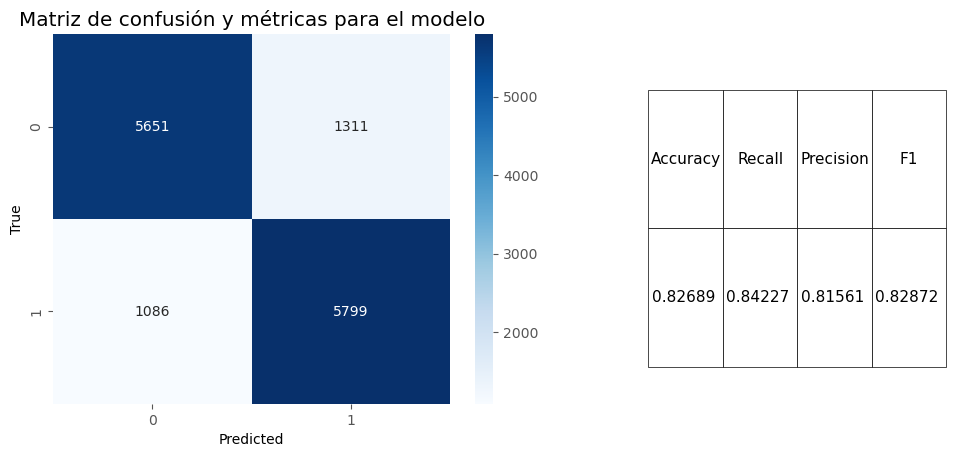

In [ ]:
make_prediction(best_knn, x_test, y_test)

De la matriz de confusión podemos apreciar como de los 13847 casos se obtuvieron:

*   5649 Verdaderos Negativos
*   5799 Verdaderos Positivos
*   1313 Falsos Positivos
*   1086 Falsos Negativos

Lo cual nos indica un porcentaje de alrededor del, 82% de aciertos (Accuracy), 84% de exhaustividad (Recall), 82% precisión y un rendimiento F1 de 0.83.

Vemos entonces como optimizar los parametros através de Cross validation nos permite obtener un ajuste al modelo mejorando el score


## SVM

Los sets de entrenamiento ya se encuentran previamentes estandarizados.

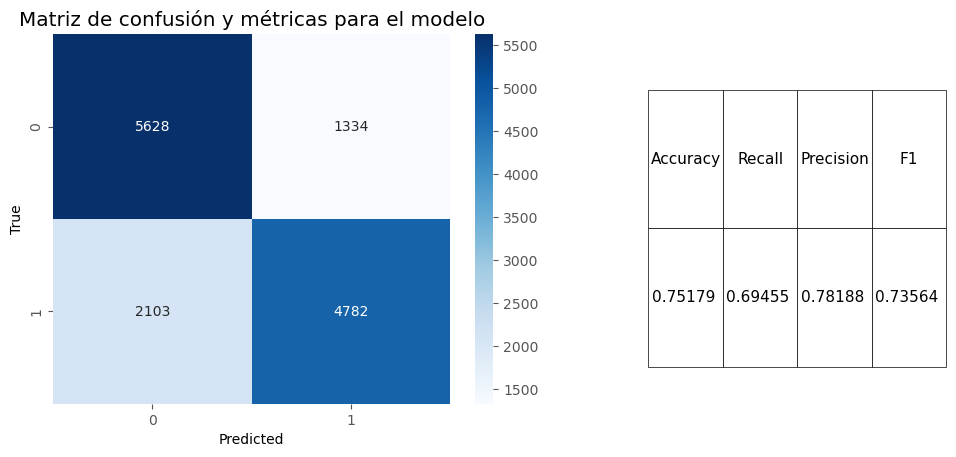

In [ ]:
svm = SVC()

#Lo entreno con los datos sin escalar
svm.fit(x_train, y_train)

#Hago la prediccion y calculo las métricas
y_pred=svm.predict(x_test)
metricas_modelo(y_test, y_pred)

De la matriz de confusión podemos apreciar como de los 13847 casos se obtuvieron:

*   5628 Verdaderos Negativos
*   4782 Verdaderos Positivos
*   1334 Falsos Positivos
*   2103 Falsos Negativos

Lo cual nos indica un porcentaje de alrededor del, 75% de aciertos (Accuracy), 69% de exhaustividad (Recall), 79% precisión y un rendimiento F1 de 0.74.



### PCA

Text(0, 0.5, 'Varianza Explicada (%)')

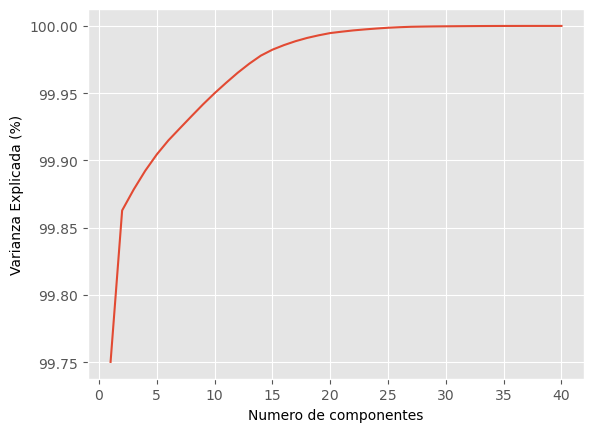

In [ ]:
# PCA sobre los datos previamente escalados
pca = PCA(n_components = None)
pca.fit(x_train)

#Cantidad de Componentes
componentes = len(pca.explained_variance_ratio_) 

#Grafico la Varianza Explicada 
plt.plot(range(1,componentes+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada (%)")

Consideramos que a partir de las **20 columnas** ya se consigue una condensación de información suficiente para el entrenamiento del modelo

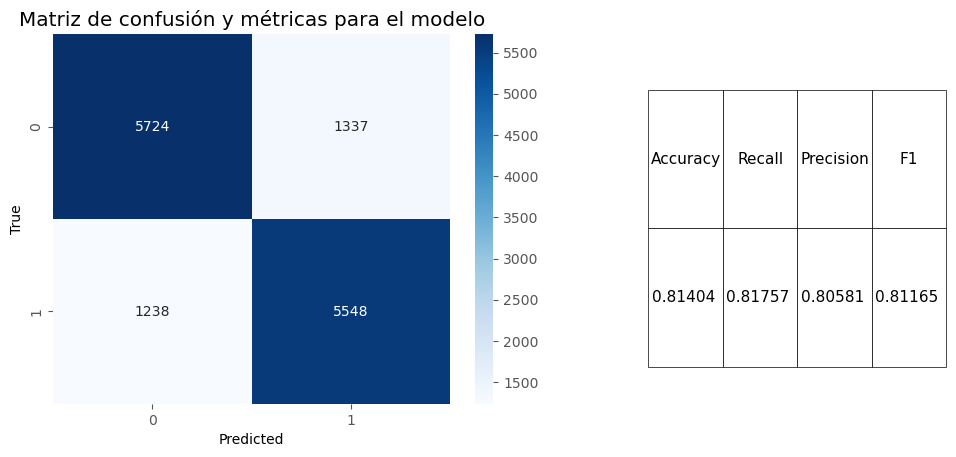

In [ ]:
#Defino el tipo de escalado, la transformacion PCA y el modelo
_sc = StandardScaler()
_pca = PCA(n_components = 20)
_model = SVC()

#Creo un pipeline
svm_model = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('svm', _model)
])

#Entreno sobre los datos que serán previamente escalados y transformados
svm_model.fit(x_train,y_train)

#Hago la predicción y calculo las métricas
y_pred_pca=svm_model.predict(x_test)
metricas_modelo(y_pred_pca,y_test)

De la matriz de confusión podemos apreciar como de los 13847 casos se obtuvieron:

*   5730 Verdaderos Negativos
*   5552 Verdaderos Positivos
*   1333 Falsos Positivos
*   1232 Falsos Negativos

Lo cual nos indica un porcentaje de alrededor del, 81% de aciertos (Accuracy), 82% de exhaustividad (Recall), 81% precisión y un rendimiento F1 de 0.81.

Logramos así una mejora sustancial respecto al inicial en cuanto a metricas y ahorro temporal, esto gracias a la reducción de variables conservando los componentes principales

In [ ]:
pca = PCA()
componentes = pca.fit_transform(x_train)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    componentes,
    labels=labels,
    dimensions=range(3),
    color=y_train
)

fig.update_traces(diagonal_visible=False)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### Kernels

#### Radial

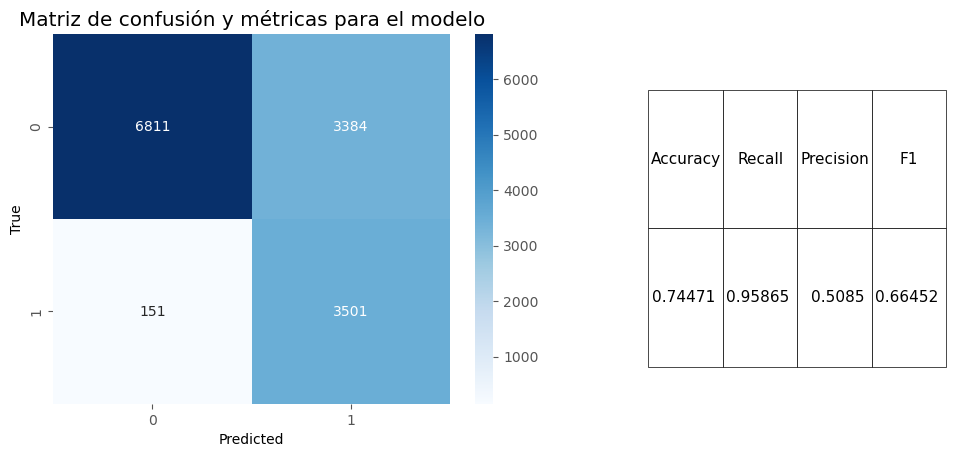

In [ ]:
#Creo un clasificador con kernel radial y lo entreno sobre los datos escalados
clf = SVC(kernel='rbf', C=5, gamma=10)
clf.fit(x_train, y_train)

#Hago la predicción y calculo las métricas
y_pred_rad=clf.predict(x_test)
metricas_modelo(y_pred_rad,y_test)

De la matriz de confusión podemos apreciar como de los 13847 casos se obtuvieron:

*   6811 Verdaderos Negativos
*   3501 Verdaderos Positivos
*   3384 Falsos Positivos
*   151 Falsos Negativos

Lo cual nos indica un porcentaje de alrededor del, 74% de aciertos (Accuracy), 96% de exhaustividad (Recall), 51% precisión y un rendimiento F1 de 0.66.

Vemos que hay una mejora importantisima en cuanto a la exhaustividad pero también existe un impacto semejante y negativo en la precisión. Esto nos indica que el kernel radial puede modelar mejor los patrones complejos en los datos que se asocian con los casos negativos pero no así los que se asocian a los casos positivos


#### Lineal

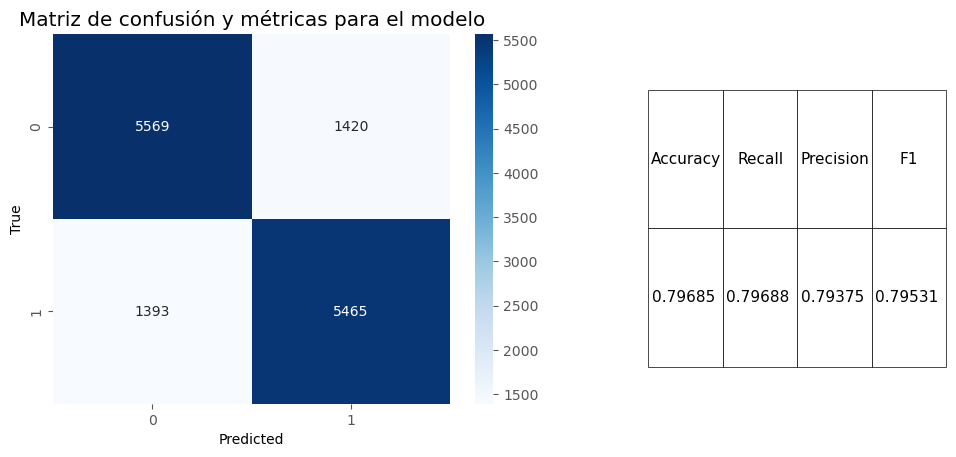

In [ ]:
#Creo un clasificador con kernel lineal y lo entreno sobre los datos escalados
clf = SVC(kernel='linear', C=5)
clf.fit(x_train, y_train)

#Hago la predicción y calculo las métricas
y_pred_lin=clf.predict(x_test)
metricas_modelo(y_pred_lin,y_test)

De la matriz de confusión podemos apreciar como de los 13847 casos se obtuvieron:

*   5566 Verdaderos Negativos
*   5486 Verdaderos Positivos
*   1399 Falsos Positivos
*   1396 Falsos Negativos

Lo cual nos indica un porcentaje de alrededor del, 80% de aciertos (Accuracy), 80% de exhaustividad (Recall), 80% precisión y un rendimiento F1 de 0.80.

Vemos que a diferencia del radial, con el lineal se obtiene un rendimiento f1 mas elevado, por lo que tiende a ser mucho mas equilibrado en cuanto a FP y FN 



## Random Forest

### Base

In [ ]:
rfc_default = RandomForestClassifier()
rfc_default.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#Creamos un clasificador con hiperparámetros arbitrarios
rfc = RandomForestClassifier(max_features='auto', 
                             oob_score=True, 
                             random_state=2, 
                             n_jobs=-1,
                             criterion="entropy", 
                             min_samples_leaf=5,
                             min_samples_split=5,
                             n_estimators=50 )
#Entrenamos el modelo
rf_model = rfc.fit(X = x_train, y = y_train)

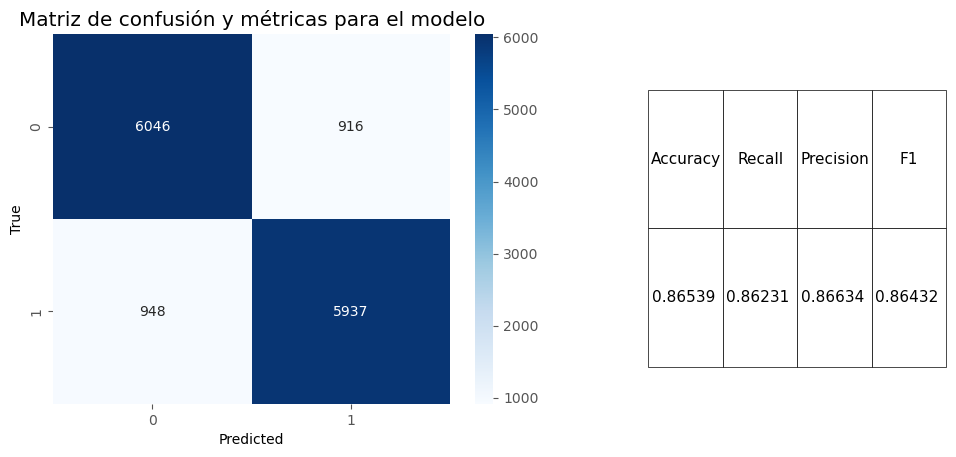

In [ ]:
make_prediction(rf_model, x_test, y_test)

De la matriz de confusión podemos apreciar como de los 13847 casos se obtuvieron:

*   6046 Verdaderos Negativos
*   5937 Verdaderos Positivos
*   948 Falsos Positivos
*   916 Falsos Negativos

Lo cual nos indica un porcentaje de alrededor del, 87% de aciertos (Accuracy), 86% de exhaustividad (Recall), 87% precisión y un rendimiento F1 de 0.86.



#### Gráfico

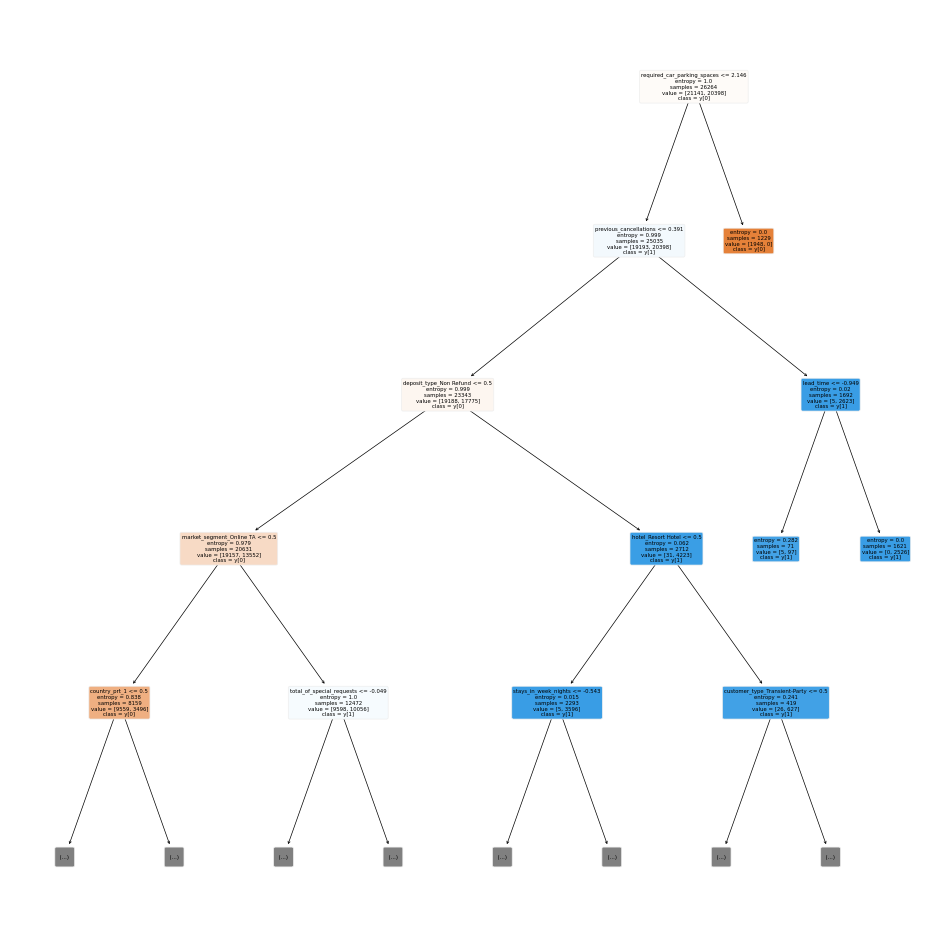

In [ ]:
plot_tree(x_train, rf_model)

### Hiperparametros optimizados por CV

En este caso optamos por utilizar GridSearch

In [41]:
rf_class = RandomForestClassifier(oob_score=True, random_state=1, n_jobs=-1)

params = { "criterion" : ["gini", "entropy"], 
          "min_samples_leaf" : [1, 5, 10], 
          "min_samples_split" : [2, 4, 10, 12, 16], 
          "n_estimators": [10,20, 50] }

#Encontramos el mejor estimado utilizando Grid Search con 10 folds
rf_cv_best = Grid_Cross_Validation(x_train, y_train, rf_class, params, 10)

/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/martin-gp/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: 

Resultados del Cross Validation
_______________________________
Tiempo transcurrido:  01:13  minutos
_______________________________
Mejores hiperparametros:  {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Mejor métrica F1:  0.877981254956072


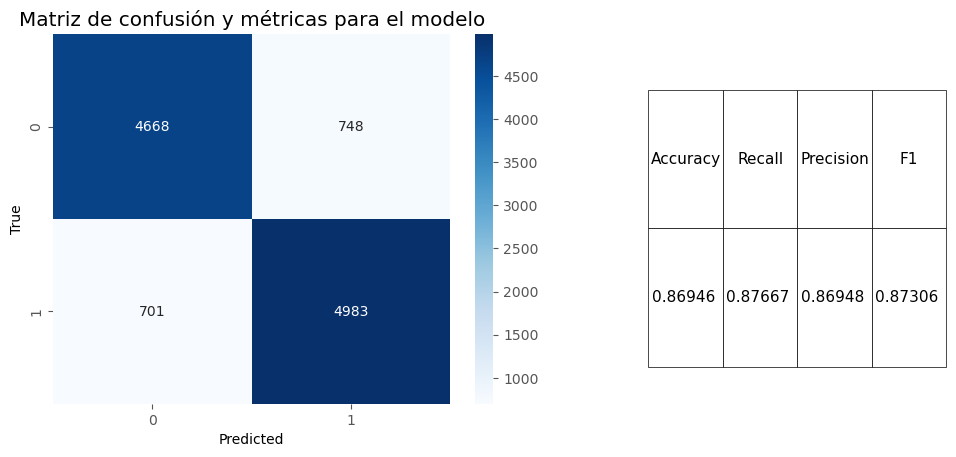

In [42]:
make_prediction(rf_cv_best, x_test, y_test)

De la matriz de confusión podemos apreciar como de los 13847 casos se obtuvieron:

*   6091 Verdaderos Negativos
*   6017 Verdaderos Positivos
*   871 Falsos Positivos
*   868 Falsos Negativos

Lo cual nos indica un porcentaje de alrededor del, 87% de aciertos (Accuracy), 87% de exhaustividad (Recall), 87% precisión y un rendimiento F1 de 0.87.

Vemos que respecto al modelo base hay una mejora en los casos de TN pero es aún mayor la mejora en los casos de Verdaderos positivos, este impacto generado por la optimización de hiperparametros nos posibilita un F1-score mas grande

In [43]:
best_model_submission["name"] = "RandomForestCVGridSearch"
best_model_submission["model"] = rf_cv_best

### Analisis de la importancia de las features

In [19]:
importances = sorted(list(zip(x_train.columns.to_list(), rf_cv_best.feature_importances_)), key=lambda x: -x[1])
importances

[('lead_time', 0.13064982811414164),
 ('country_prt_1', 0.11271845406340505),
 ('deposit_type_Non Refund', 0.10547815678636022),
 ('adr', 0.0704967661628333),
 ('agent', 0.06582471395280502),
 ('total_of_special_requests', 0.05499682546814687),
 ('arrival_date_week_number', 0.050951093762672164),
 ('arrival_date_day_of_month', 0.05009648862658749),
 ('misassigned_room', 0.047771354961118596),
 ('market_segment_Online TA', 0.03579080024159987),
 ('stays_in_week_nights', 0.033428739761815526),
 ('arrival_date_year', 0.030217851106816206),
 ('arrival_date_month', 0.02885799875335423),
 ('customer_type_Transient', 0.02523270718215438),
 ('required_car_parking_spaces', 0.023279586308191533),
 ('market_segment_Groups', 0.02048300296484224),
 ('customer_type_Transient-Party', 0.02045558163813367),
 ('market_segment_Offline TA/TO', 0.02007305010442975),
 ('hotel_Resort Hotel', 0.009839077608875974),
 ('distribution_channel_TA/TO', 0.009757039927096624),
 ('adults', 0.008133941971568205),
 ('ma

In [20]:
acum = 0

for column in importances:
  acum += column[1]
  
print("Información acumulada: ", acum)

Información acumulada:  0.9999999999999999


Buscamos un límite dónde los features representen un porcentaje considerable

In [21]:
acum = 0
last_main_features = 0
print("Cantidad de columnas totales: ", len(importances))
for i, column in enumerate(importances):
  acum += column[1]
  if(acum >= 0.95):
    last_main_features = i
    print("Cantidad de columnas con alta importancia: ", i+1)
    print("Información acumulada: ", acum)
    print('Cantidad de columnas a descartar: ', len(importances)-(i+1))
    break

main_columns = [item[0] for item in  importances[0:last_main_features+1]]
print("Columnas principales: ", main_columns)


Cantidad de columnas totales:  39
Cantidad de columnas con alta importancia:  21
Información acumulada:  0.9545330594669484
Cantidad de columnas a descartar:  18
Columnas principales:  ['lead_time', 'country_prt_1', 'deposit_type_Non Refund', 'adr', 'agent', 'total_of_special_requests', 'arrival_date_week_number', 'arrival_date_day_of_month', 'misassigned_room', 'market_segment_Online TA', 'stays_in_week_nights', 'arrival_date_year', 'arrival_date_month', 'customer_type_Transient', 'required_car_parking_spaces', 'market_segment_Groups', 'customer_type_Transient-Party', 'market_segment_Offline TA/TO', 'hotel_Resort Hotel', 'distribution_channel_TA/TO', 'adults']


Se reducen todos los set de entrenamiento y testing con dichas columnas para una posterior evaluación con diferentes métodos

In [22]:
x_train_reduced = x_train[main_columns].copy()
x_test_reduced = x_test[main_columns].copy()
x_test_submission = x_test_submission[main_columns].copy()

## XGBoost

### Comparación entre entrenamiento con y sin reducción de features

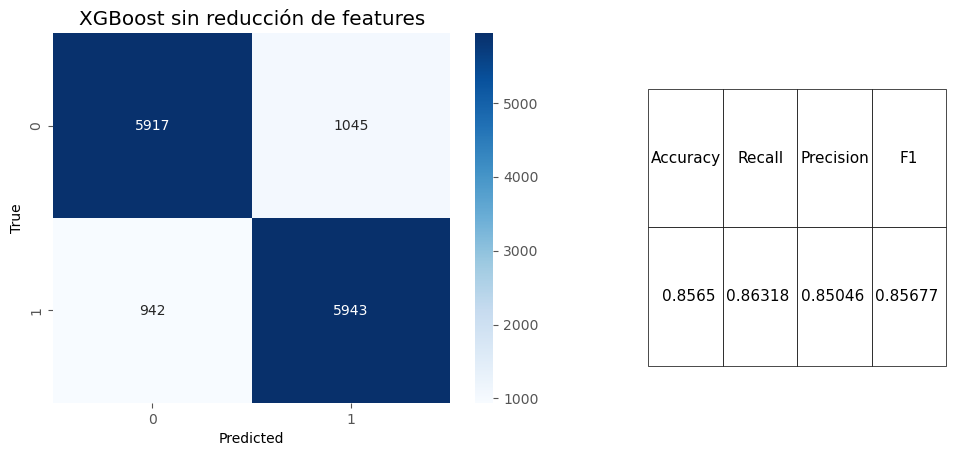

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=50)

#Se entrena modelo con el set completo
xgb_model.fit(x_train, y_train)

xgb_y_pred=xgb_model.predict(x_test)

metricas_modelo(y_test, xgb_y_pred, "XGBoost sin reducción de features")


De la matriz de confusión podemos apreciar como de los 13847 casos se obtuvieron:

*   5917 Verdaderos Negativos
*   5943 Verdaderos Positivos
*   1045 Falsos Positivos
*   942 Falsos Negativos

Lo cual nos indica un porcentaje de alrededor del, 86% de aciertos (Accuracy), 86% de exhaustividad (Recall), 85% precisión y un rendimiento F1 de 0.86.



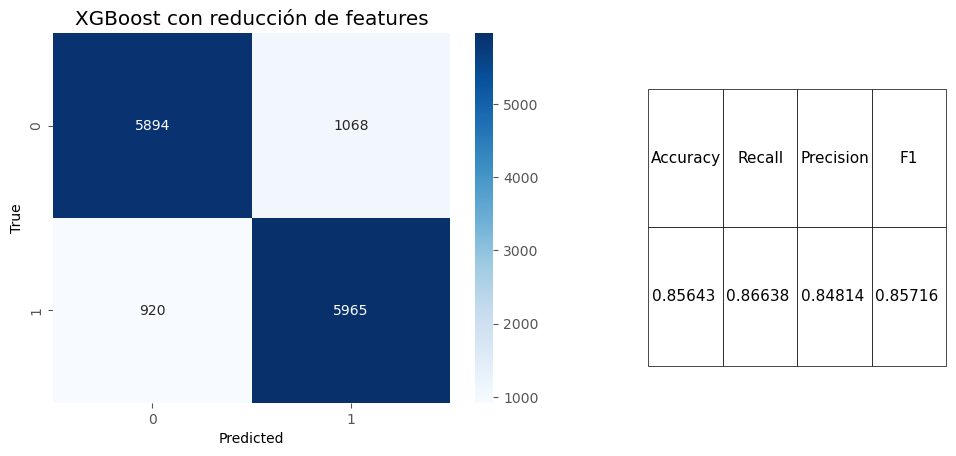

In [ ]:
#Se entrena modelo con un set reducido
xgb_model.fit(x_train_reduced, y_train)

xgb_red_y_pred=xgb_model.predict(x_test_reduced)

metricas_modelo(y_test, xgb_red_y_pred, "XGBoost con reducción de features")

Exceptuando el caso de la Precisión, podemos ver que el entrenamiento con un set reducido mejor la mayoría de las méticas, sobretodo la F1, métrica a la cual le damos prioridad.

### Hiperparametros optimizados por CV

In [ ]:
xgb_class = xgb.XGBClassifier()
xgb_class.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
#Grilla de Parámetros
params = { 
    'learning_rate': [0.05, 0.10, 0.15, 0.2, 0.3, 0.4], # tasa de aprendizaje
    'max_depth': range(5, 15), #máxima profundidad de cada árbol
    'n_estimators': range(30, 60), #cantidad de árboles a construir
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
    #'gamma':[ i/10.0 for i in range(0,5)],
}

#Random Search con 10 Folds y 20 iteraciones
k = 10
i = 20
best_xgb_model = Randomized_Cross_Validation(x_train_reduced, y_train, xgb_class, params, k, i)

Resultados del Cross Validation
_______________________________
Tiempo transcurrido:  02:15  minutos
_______________________________
Mejores hiperparametros:  {'reg_alpha': 0.05, 'n_estimators': 57, 'max_depth': 12, 'learning_rate': 0.2}
Mejor métrica F1:  0.8702150566524409


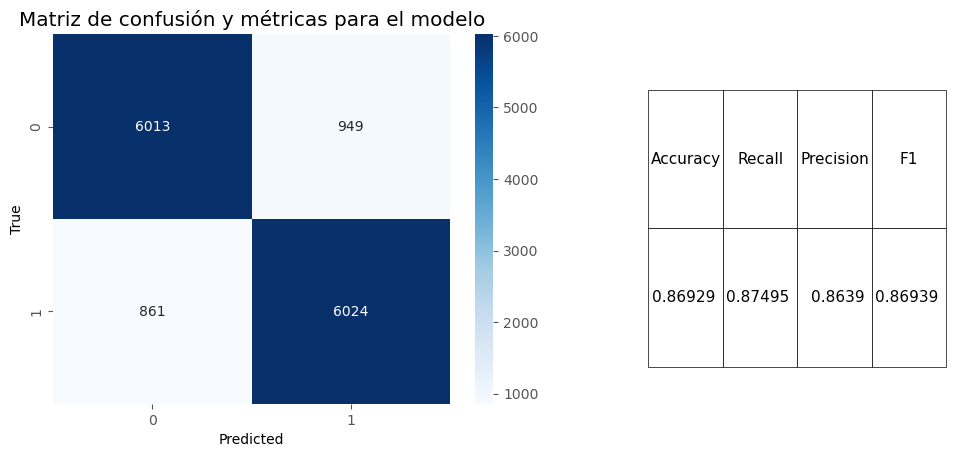

In [ ]:
make_prediction(best_xgb_model, x_test_reduced, y_test)

#0,86996 sin reducir
#0,86905 reducido y con alpha

De la matriz de confusión podemos apreciar como de los 13847 casos se obtuvieron:

*   6013 Verdaderos Negativos
*   6031 Verdaderos Positivos
*   949 Falsos Positivos
*   854 Falsos Negativos

Lo cual nos indica un porcentaje de alrededor del, 87% de aciertos (Accuracy), 88% de exhaustividad (Recall), 86% precisión y un rendimiento F1 de 0.87.

Vemos que hay una notoria mejora general tras la optimización de hiperparametros por cross validation aunque es apenas mas grande la mejora de los casos de TN que la de TP


## Ensamble de modelos

### Voting

Tiempo transcurrido:  00:02  minutos
_______________________________


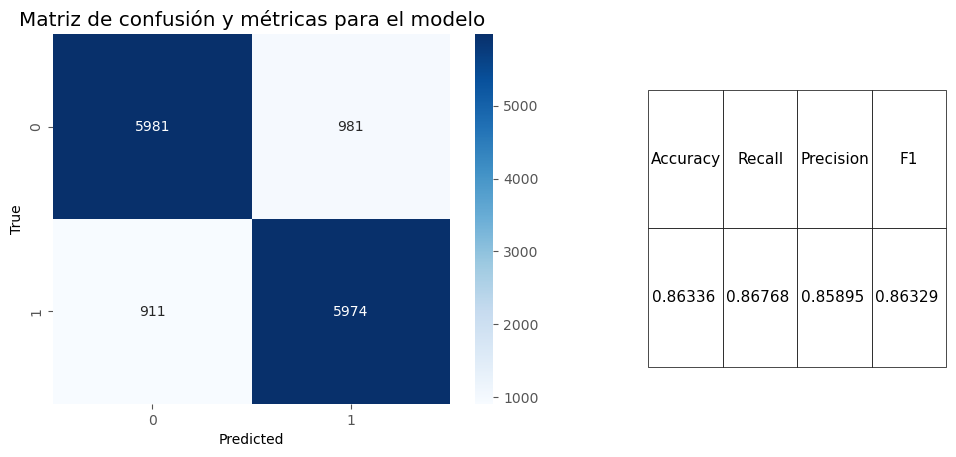

In [ ]:
#Creo clasificadores

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier(criterion= 'entropy',
                                min_samples_leaf= 1,
                                min_samples_split= 4,
                                n_estimators= 50)
knn_clf = KNeighborsClassifier(weights= 'distance',
                              n_neighbors= 19, 
                              metric= 'manhattan',
                              algorithm= 'brute')

#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

#Entreno el ensemble

t_inicio = time.perf_counter()
vot_clf.fit(x_train_reduced, y_train)
t_final = time.perf_counter()

timer_flag(t_final-t_inicio)

#Evaluo en conjunto de test
y_pred_vot = vot_clf.predict(x_test_reduced)

metricas_modelo(y_test, y_pred_vot)

### Stacking

In [ ]:
#Modelos Base
base_models = [('random_forest', RandomForestClassifier()),
               ('svm', SVC()),
               ('knn', KNeighborsClassifier())]

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=10)

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_class = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=kfoldcv,
                                    verbose=2)

t_inicio = time.perf_counter()
stacking_model = stacking_class.fit(x_train_reduced, y_train)
t_final = time.perf_counter()

timer_flag(t_final-t_inicio)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished


Tiempo transcurrido:  08:15  minutos
_______________________________


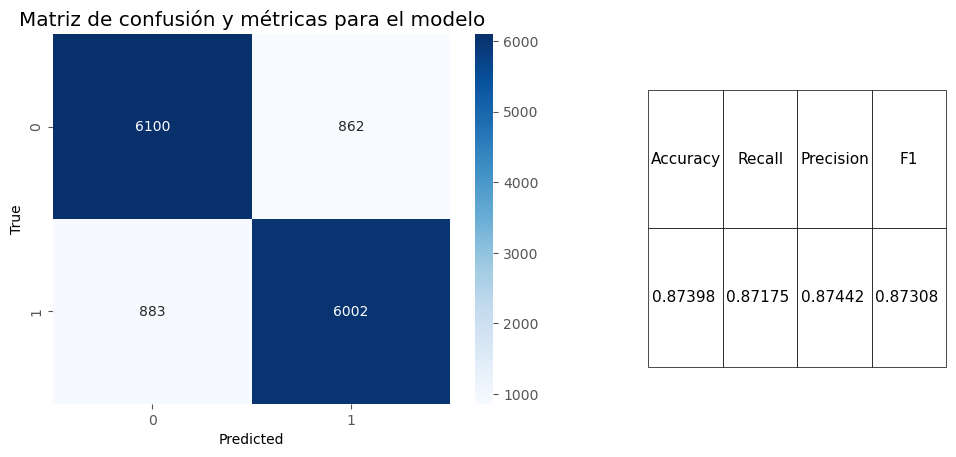

In [ ]:
make_prediction(stacking_model, x_test_reduced, y_test)

#### Comparativa entre Stacking y los modelos

In [ ]:
#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for model in base_models:
    print('Evaluating {}'.format(model[0]))
    scores = evaluate_model(model[1], x_train, y_train)
    model_scores[model[0]] = scores

stacking_scores = evaluate_model(stacking_class, x_train, y_train)
model_scores['stacking'] = stacking_scores


Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   10.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating svm


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  3.4min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating knn


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.1s finished


In [ ]:
#Grafico performance
plot_results(model_scores, name='stacking_model_cv')

## Conclusiones



Observando las metricas conseguidas por cada modelo en sus diferentes etapas de ajuste se puede elegir uno de ellos como el mejor predictor.

 Para esto no solo deben ser tomadas en cuenta las metricas como resultado de cada modelo sino también el objetivo por el cual se quiere predecir el target. Es decir, si bien las metricas son los resultados numéricos en los que nos basamos para realizar una elección, el contexto es fundamental para saber cual metrica utilizar o dar prioridad. 
 
 Por ejemplo, si supieramos que nuestro objetivo es predecir is_canceled porque se busca incorporar un sistema de automatización para anticiparse a las potenciales cancelaciones y darlas de baja con anterioridad priorizariamos la metrica de "Precision" porque buscamos minimizar los casos de falsos positivos

 En cambio, si lo que se busca es crear un sistema de advertencia para casos sospechosos priorizariamos la metrica de "Recall" ya que querríamos minimizar los casos de falsos negativos, osea, que nos queden la menor cantidad posible de reservas canceladas como no canceladas

 Como lo que hacemos es un analisis general de los datos sin importarnos el objetivo creemos que es tan importante la metrica de precision como la de recall, por lo que elegimos siempre trabajar con F1-score, ya que brinda información balanceada sobre ambas dos.


 Habiendo dicho esto observamos que el modelo predictivo con mayor calificación F1-score es el conseguido utilizando Random Forest y optimizando sus parametros por Cross Validation de manera unimétrica a través del F1-score con GridSearch. Este no solo fué el mejor predictor sino que demostró tener un tiempo de ejecución mas acotado que el de otros modelos como el XGBoost
 

# Submission

Se realiza una prediccion a partir de las columnas de decision del dataframe de test

In [ ]:
y_pred = best_model_submission["model"].predict(x_test_submission)
df_submission = pd.DataFrame({"id": df_test_submission["id"], "is_canceled": y_pred})
df_submission

NameError: name 'best_model_submission' is not defined

In [ ]:
file_name = 'submission-' + best_model_submission["name"] + '-' + datetime.now(timezone(timedelta(hours=-3))).strftime("%d-%m-%H:%M") + '.csv'
df_submission.to_csv(file_name, encoding = 'utf-8-sig', index=False) 
#files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
df_train_reduced = df_train[main_columns].copy()
df_test_reduced = df_test_submission[main_columns].copy()

df_train_reduced.to_csv('hotels_train_reduced.csv', encoding = 'utf-8-sig', index=False) 
files.download('hotels_train_reduced.csv')

df_test_reduced.to_csv('hotels_test_reduced.csv', encoding = 'utf-8-sig', index=False) 
files.download('hotels_test_reduced.csv')

KeyboardInterrupt: 

# Model save

In [44]:
model_file_name = best_model_submission["name"] + ".pickle"

# save model
pickle.dump(best_model_submission["model"], open(model_file_name, "wb"))